## Metropolis Hastings and Hamiltonian MCMC
##### Dano Gillam

In [193]:
import autograd
from matplotlib import pyplot as plt
import seaborn
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Part 1: Metropolis Hastings

In [164]:
from __future__ import division
import numpy as np

def p( x, t=1.0 ):
    return np.exp(-10*t*((x-2)**2) ) + 0.3*np.exp( -0.5*10*t*((x+1)**2) )
def q( x, sigma):
    return np.random.normal(x,sigma)

In [165]:
variances = [0.1,1.0,10.0]

In [166]:
def metropolis_hastings(steps,sigma):
    X = np.zeros(steps+1)
    #initialize x^0
    X[0]= 0
    for t in xrange(steps):
        x = X[t]
        xp = q(x,sigma)
        alpha = p(xp)*q(xp,sigma)/ ( p(x)*q(x,sigma)  )
        r = min(1,alpha)
        u = np.random.rand()
        if u<r: X[t+1] = xp
        else: X[t+1] = X[t]
    return X

def plot_metropolis_hastings(steps,sigma):
    
    
    #plot histogram
    Y = metropolis_hastings(steps,sigma)
    plt.hist(Y,100,normed=True)
    plt.xlim(-3,3)
    X = np.linspace(-3,3,200)
    true_Y = p(X)
    plt.xlabel('state')
    plt.ylabel('count')
    plt.plot(X,true_Y,'r')
    plt.show()
    
    for i in xrange(3):
        Y = metropolis_hastings(steps,sigma)
        plt.plot(Y)
    plt.title('State evolution: sigma = '+str(sigma))
    plt.xlabel('time')
    plt.ylabel('state')
    plt.show()

#### Sigma = .1

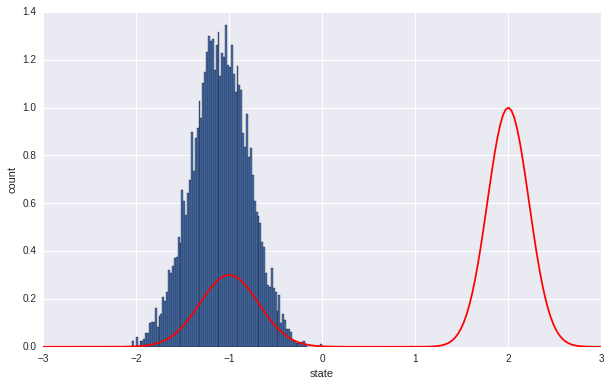

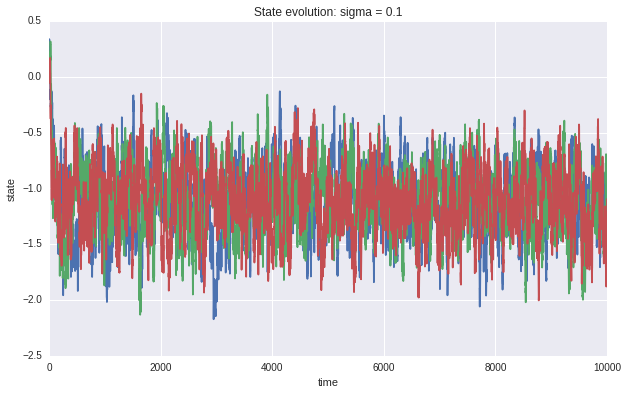

In [167]:
plot_metropolis_hastings(10000,.1)

#### Sigma = 1

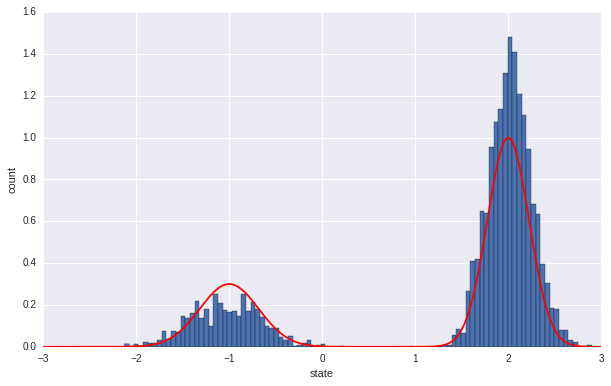

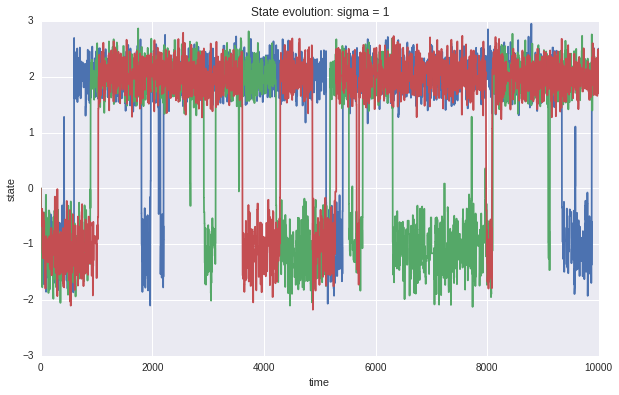

In [168]:
plot_metropolis_hastings(10000,1)

#### Sigma = 10

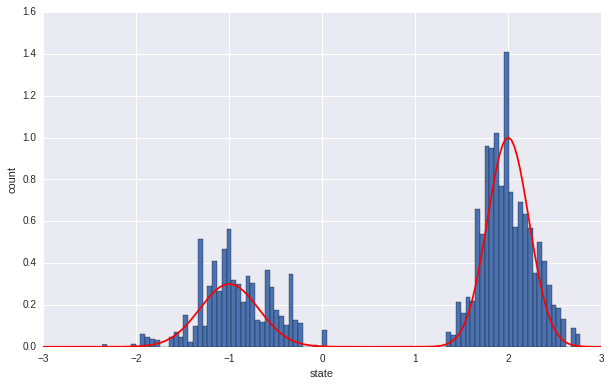

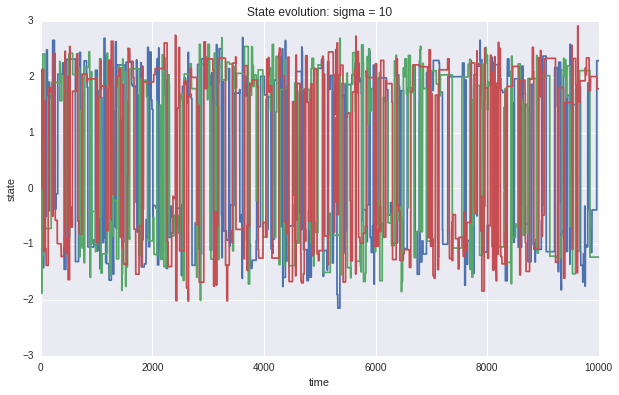

In [169]:
plot_metropolis_hastings(10000,10)

### Part 2: Hamiltonian MCMC

In [170]:
from autograd import grad
import autograd.numpy as np
U = lambda x: -np.log(p(x))
grad_U = grad( U )

In [187]:
def hmc(U,grad_U, eps,L, current_pos,sigma=1):
    #pos = position
    #mom = momentum
    
    pos = current_pos
    mom = np.random.normal(0,sigma**(.5))
    current_mom = mom
    
    # Make a half step for momentum at the beginning
    mom = mom- eps * grad_U(pos) / 2.
    
    for i in xrange(1,L):
        # Make a full step for the position
        pos = pos + eps * mom 
        # Make a full step for the momentum, except at end of trajectory
        mom = mom - eps * grad_U( pos )
    pos = pos + eps * mom 
    
    # Make a half step for momentum at the end.
    mom = mom - eps * grad_U( pos ) / 2
    # Negate momentum at end of trajectory to make the proposal symmetric
    mom = -mom 
    
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_pos )
    current_K = current_mom**2 / 2.
    proposed_U = U(pos )
    proposed_K = mom**2 / 2.
    
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    
    if (np.random.rand() < np.exp(current_U -proposed_U +current_K -proposed_K )):
        return (pos ) # accept
    else:
        return (current_pos ) # reject



def mh_hmc(steps,sigma,epsilon,L):
    X = np.zeros(steps+1)
    #initialize x^0
    X[0]= 0
    for t in xrange(steps):
        print '\rstep ',t,
        X[t+1] = hmc(U,grad_U,epsilon,L,X[t],sigma)
    return X


def plot_mh_hmc(steps,sigma,epsilon,L):
    
    
    #plot histogram
    Y = mh_hmc(steps,sigma,epsilon,L)
    plt.hist(Y,50,normed=True)
    plt.xlabel('state')
    plt.ylabel('count')
    X = np.linspace(-3,3,200)
    true_Y = p(X)
    plt.plot(X,true_Y,'r')
    plt.show()
    
    plt.plot(Y)
    plt.plot(mh_hmc(steps,sigma,epsilon,L))
    plt.plot(mh_hmc(steps,sigma,epsilon,L))

    plt.title('State evolution')
    plt.xlabel('time')
    plt.ylabel('state')
    plt.show()

step  999

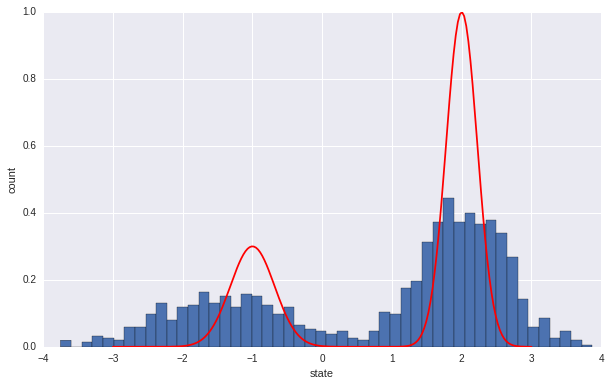

step  999

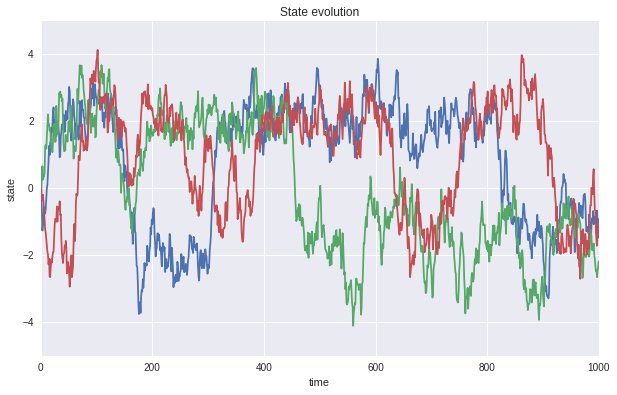

In [191]:
steps = 1000
sigma = 10
epsilon = .01
L = 10

plot_mh_hmc(steps,sigma,epsilon,L)

### Part 3: Observations

In [186]:
def mh_hmc_acceptance_rate():
    Y0 = mh_hmc(steps,sigma,epsilon,L)
    Y1 = metropolis_hastings(steps,1.)
    acc0 = 0
    acc1 = 1
    for i in xrange(1,len(Y0)):
        if Y0[i]!=Y0[i-1]:acc0+=1
        if Y1[i]!=Y1[i-1]:acc1+=1
    print 
    print 'mh_hmc acceptance rate = ', acc0/steps
    print 'hmc acceptance rate    = ', acc1/steps
mh_hmc_acceptance_rate()

step  999
mh_hmc acceptance rate =  0.999
hmc acceptance rate    =  0.225


#1
The hmc accepts almost all state change proposals, while the hmc accepts less than 25% of the proposals (with a sigma of 1).

#2
Some inference algorithms never 'bounce' to the other mode and so they never explore both modes of the density.

#3
Some algorithms have lower variances and so, they reject more proposals and stay in the same state repeatedly. This is bad right? We are missing a lot of information about the system. Not knowing there is another mode is bad.

#4  
The best value for variance: $\sqrt{10}$  
The best value for epsilon : $.01$  
I found these values from lots and lots of trials. I knew they were good because the modes appeared consistantly in the correct locations.